# Deep Neural Network (2 hidden layer)

In [1]:
import csv
import os
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Load labeled dataset

In [2]:
global labeled_dataset
labeled_dataset = []

# reference: http://pythoncentral.io/how-to-traverse-a-directory-tree-in-python-guide-to-os-walk/
dataset_path = './labeled_dataset'

# 이중 폴더 속에 있는 파일들을 Load하기 위한 이중 for문
for dirName, subdirList, fileList in os.walk(dataset_path):
    #print('Found directory: %s' % dirName)
    for fname in fileList:
        
        # 파일의 절대 경로를 만들어 주기 위한 코드
        file_path = dirName+'/'+fname # ex: ./test_dataset/Telegraph/Google-2010-Telegraph-20160706164841234.csv
        temp_str = dirName.split('/') # publisher 단어를 뽑기 위한 과정
        publisher = temp_str[-1] # 현재 publisher 폴더이름 추출
        
        with open(file_path, 'rb') as f:
            reader = csv.reader(f)
            labeled_dataset += list(reader)

#labeled_dataset = np.array(labeled_dataset)

### Split training and testing dataset (for non-seq data)

In [3]:
##### Class Imbalance Problem
# class가 구성이 한쪽으로 치우쳐져 있기 때문에, class별로 나눠서 train/test 균등분리가 필요하다. 
# 또는 majority class를 undersampling, minority class를 oversampling하는 방법도 있다.

### Filter dataset based on class
class_1_dataset = [row for row in labeled_dataset if '1' == row[0]]
class_2_dataset = [row for row in labeled_dataset if '2' == row[0]]
class_3_dataset = [row for row in labeled_dataset if '3' == row[0]]
class_4_dataset = [row for row in labeled_dataset if '4' == row[0]]

### Split training/test dataset based on class
class_1_train, class_1_test = train_test_split(class_1_dataset, train_size = 0.8)
class_2_train, class_2_test = train_test_split(class_2_dataset, train_size = 0.8)
class_3_train, class_3_test = train_test_split(class_3_dataset, train_size = 0.8)
class_4_train, class_4_test = train_test_split(class_4_dataset, train_size = 0.8)

### Join dataset
train_dataset = class_1_train+class_2_train+class_3_train+class_4_train
test_dataset = class_1_test+class_2_test+class_3_test+class_4_test

### Shuffle dataset
shuf_train_dataset = shuffle(train_dataset)
shuf_test_dataset = shuffle(test_dataset)

### Split X and Y
X_train, X_test = [], []
Y_train, Y_test = [], []
temp1, temp2 = [], []

for idx, row in enumerate(shuf_train_dataset):
    for j in range(1, 10): # csv file에서 feature가 있는 index (1~9)
        temp1.append(shuf_train_dataset[idx][j])
    X_train.append(temp1)
    temp1 = [] # temp 0으로 초기화

for idx, row in enumerate(shuf_test_dataset):
    for j in range(1, 10):
        temp2.append(shuf_test_dataset[idx][j])
    X_test.append(temp2)
    temp2 = [] 

for idx, row in enumerate(shuf_train_dataset): Y_train.append(shuf_train_dataset[idx][0])
for idx, row in enumerate(shuf_test_dataset): Y_test.append(shuf_test_dataset[idx][0])
    
### Convert to numpy array with data-type
X_train = np.array(X_train, dtype='float32')
X_test = np.array(X_test, dtype='float32')
Y_train = np.array(Y_train, dtype='int64')
Y_test = np.array(Y_test, dtype='int64')

In [4]:
#mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
#X_trn, Y_trn, X_test, Y_test = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

### Prepare for Model

In [5]:
# Define hyper-parameters
input_dim = 9
hidden_dim = 2
output_dim = 4

alpha = 0.05 # learning rate
batch_size = 128
epoch_size = 30


# function for variables
def init_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.01))

# function for model construction
def model(X, w_h, w_h2, w_o):
    h = tf.nn.relu(tf.matmul(X, w_h))
    h2 = tf.nn.relu(tf.matmul(h, w_h2))
    return tf.matmul(h2, w_o)

# make placeholder for inputs and labels
X = tf.placeholder(tf.float32, [None, input_dim])
Y = tf.placeholder(tf.int64, [None])

# weight variable & model
w_h = init_weights([input_dim, hidden_dim])
w_h2 = init_weights([hidden_dim, hidden_dim])
w_o = init_weights([hidden_dim, output_dim])
py_x = model(X, w_h, w_h2, w_o)

# loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(py_x, Y))

# Optimization function
train_op = tf.train.AdagradOptimizer(learning_rate=alpha).minimize(loss)

# Calculate accuracy
correct = tf.nn.in_top_k(py_x, Y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

### Session initialize and training

In [6]:
trn_loss_list = list()
test_loss_list = list()
test_accuracy_list = list()
with tf.Session() as sess:    
    tf.initialize_all_variables().run()
    
    for i in range(epoch_size):
        trn_loss = 0
        for start, end in zip(range(0, len(X_train), batch_size), range(batch_size, len(X_train)+1, batch_size)):
            tmp_loss, _ = sess.run([loss, train_op], feed_dict={X: X_train[start:end], Y: Y_train[start:end]})
            trn_loss += tmp_loss
        
        trn_loss_list.append(trn_loss / 100)
        test_loss, test_acc = sess.run([loss, accuracy], feed_dict={X: X_test, Y: Y_test})
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)
        print("epoch: {} test accuracy {:0.4f}".format(i, test_acc))

epoch: 0 test accuracy 0.9695
epoch: 1 test accuracy 0.9739
epoch: 2 test accuracy 0.9739
epoch: 3 test accuracy 0.9760
epoch: 4 test accuracy 0.9782
epoch: 5 test accuracy 0.9717
epoch: 6 test accuracy 0.9368
epoch: 7 test accuracy 0.9172
epoch: 8 test accuracy 0.8889
epoch: 9 test accuracy 0.1176
epoch: 10 test accuracy 0.1198
epoch: 11 test accuracy 0.1176
epoch: 12 test accuracy 0.1068
epoch: 13 test accuracy 0.1068
epoch: 14 test accuracy 0.0980
epoch: 15 test accuracy 0.0980
epoch: 16 test accuracy 0.0980
epoch: 17 test accuracy 0.0959
epoch: 18 test accuracy 0.0980
epoch: 19 test accuracy 0.4314
epoch: 20 test accuracy 0.4815
epoch: 21 test accuracy 0.4902
epoch: 22 test accuracy 0.4967
epoch: 23 test accuracy 0.4989
epoch: 24 test accuracy 0.4989
epoch: 25 test accuracy 0.4989
epoch: 26 test accuracy 0.4989
epoch: 27 test accuracy 0.4989
epoch: 28 test accuracy 0.4989
epoch: 29 test accuracy 0.5011


## Loss plot

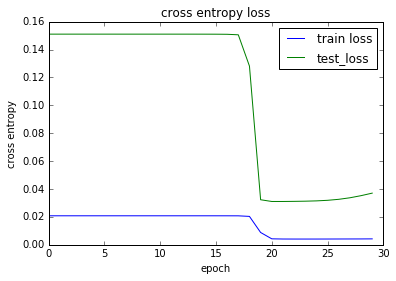

In [7]:
x = np.arange(epoch_size) # epoch size와 일치해야 한다.
plt.plot(x, trn_loss_list)
plt.plot(x, test_loss_list)
plt.title("cross entropy loss")
plt.legend(["train loss", "test_loss"])
plt.xlabel("epoch")
plt.ylabel("cross entropy")

## Accuracy plot

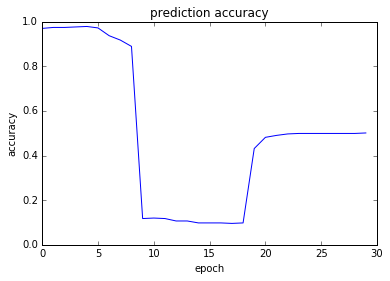

In [8]:
x = np.arange(epoch_size) # epoch size와 일치해야 한다.
plt.plot(x, test_accuracy_list)
plt.title("prediction accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy")